In [1]:
from PIL import Image
import numpy as np
import clip
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification

model, preprocess = clip.load("ViT-L/14")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

c:\Users\ilyav\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model parameters: 427,616,513
Input resolution: 224
Context length: 77
Vocab size: 49408


In [2]:
model.cuda().eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)


### Тесты, что модель загрузилась и работает

In [3]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

In [20]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 8))

for filename in [filename for filename in os.listdir('dataset') if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    print(name)
    image = Image.open(os.path.join('dataset', filename)).convert("RGB")
    original_images.append(image)
    images.append(preprocess(image))


plt.tight_layout()

0000
0001
0002
0003
0004
0005
0006
0007
0008
0009
0010
0011
0012
0013
0014
0015
0016
0017
0018
0019
0020
0021
0022
0023
0024
0025
0026
0027
0028
0029
0030
0031
0032
0033
0034
0035
0036
0037
0038
0039
0040
0041
0042
0043
0044
0045
0046
0047
0048
0049
0050
0051
0052
0053
0054
0055
0056
0057
0058
0059
0060
0061
0062
0063
0064
0065
0066
0067
0068
0069
0070
0071
0072
0073
0074
0075
0076
0077
0078
0079
0080
0081
0082
0083
0084
0085
0086
0087
0088
0089
0090
0091
0092
0093
0094
0095
0096
0097
0098
0099
0100
0101
0102
0103
0104
0105
0106
0107
0108
0109
0110
0111
0112
0113
0114
0115
0116
0117
0118
0119
0120
0121
0122
0123
0124
0125
0126
0127
0128
0129
0130
0131
0132
0133
0134
0135
0136
0137
0138
0139
0140
0141
0142
0143
0144
0145
0146
0147
0148
0149
0150
0151
0152
0153
0154
0155
0156
0157
0158
0159
0160
0161
0162
0163
0164
0165
0166
0167
0168
0169
0170
0171
0172
0173
0174
0175
0176
0177
0178
0179
0180
0181
0182
0183
0184
0185
0186
0187
0188
0189
0190
0191
0192
0193
0194
0195
0196
0197
0198
0199


<Figure size 1600x800 with 0 Axes>

In [22]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [23]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.71 GiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 13.67 GiB is allocated by PyTorch, and 11.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [15]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

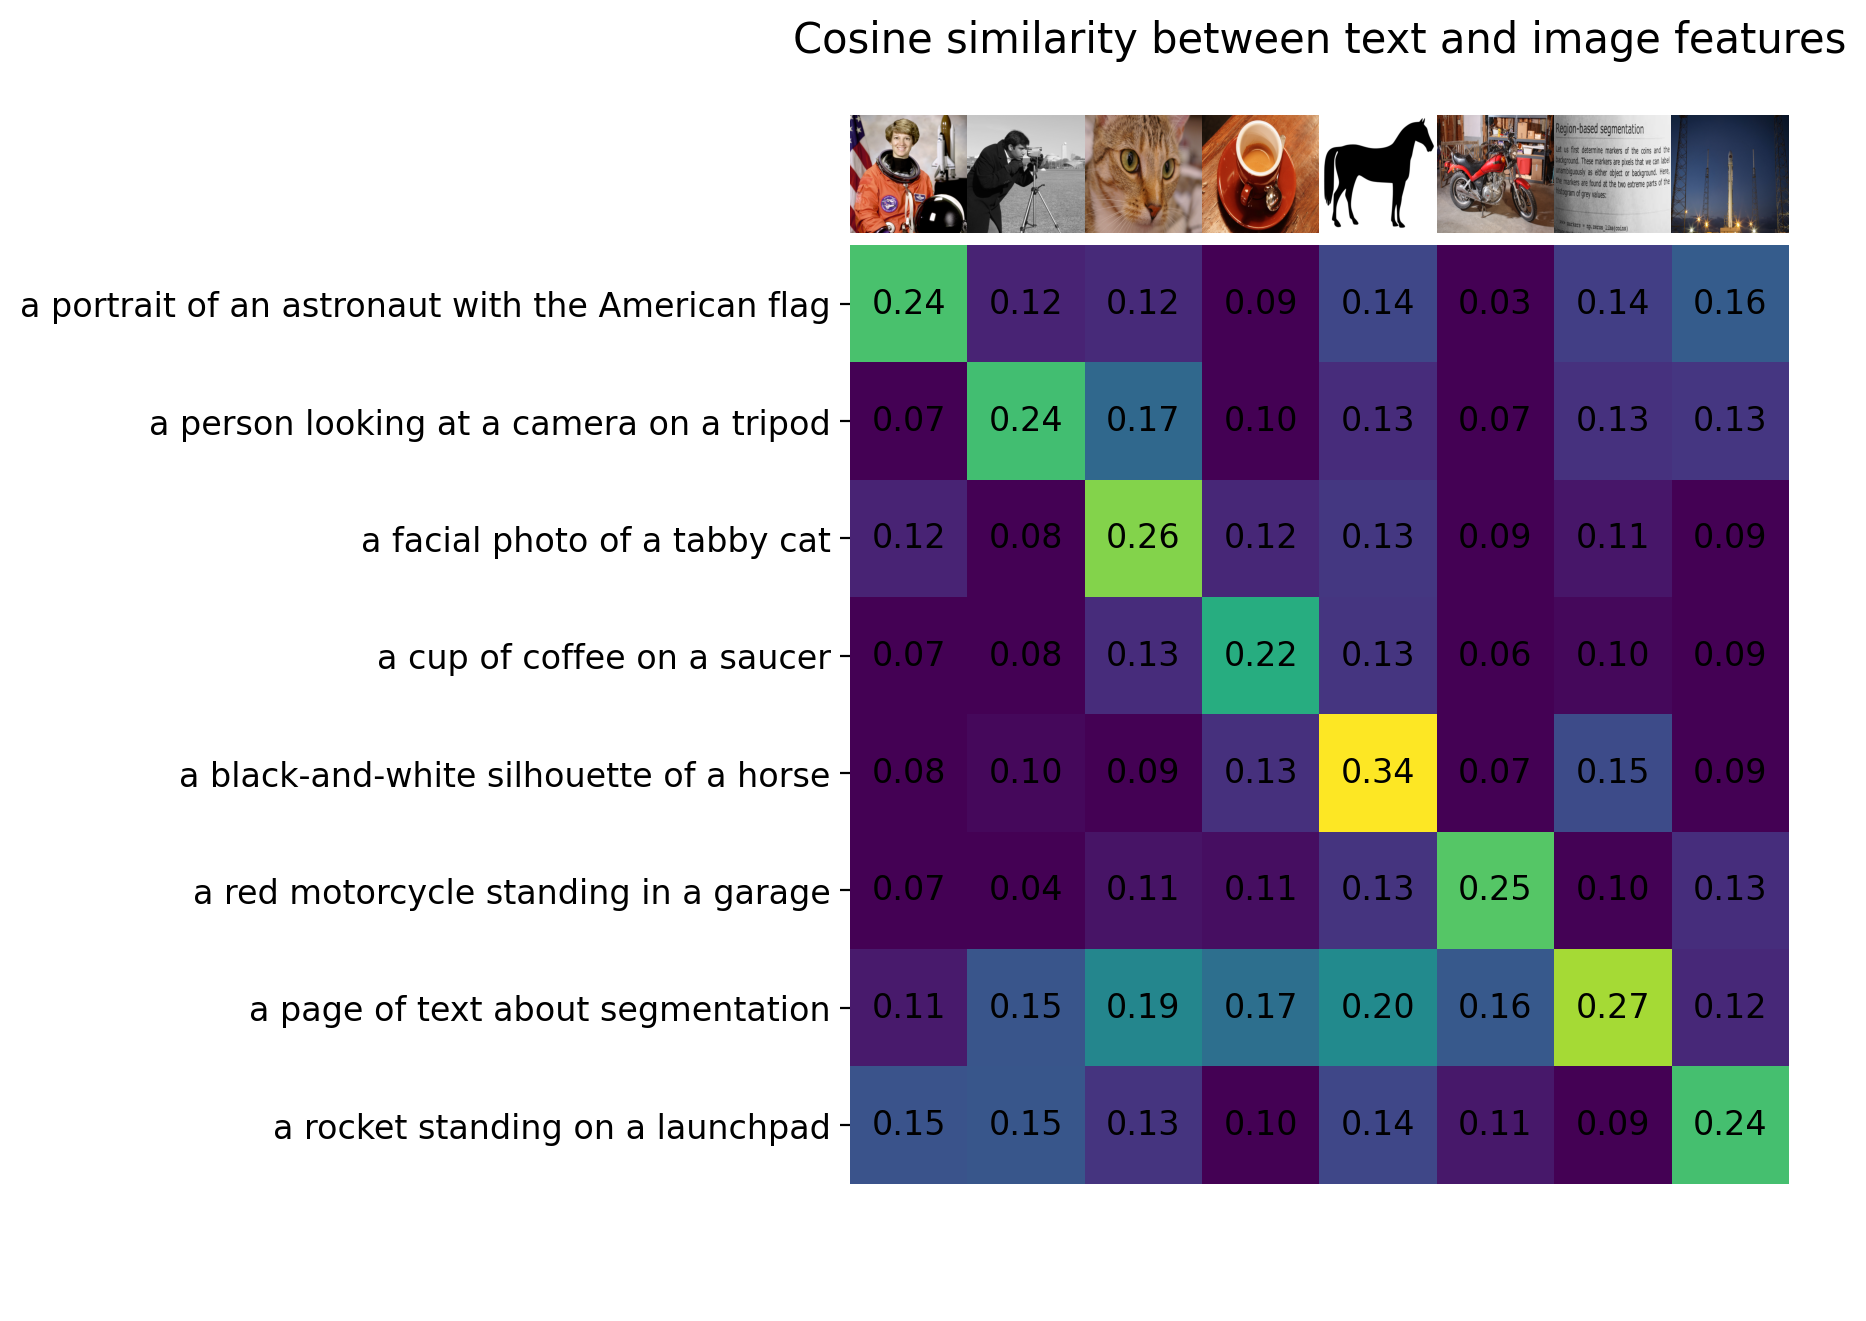

In [16]:
count = len(descriptions)

plt.figure(figsize=(11, 8))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=12)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=15)

### Zero Shot

In [17]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

100%|██████████| 169M/169M [00:35<00:00, 4.82MB/s] 


In [18]:
text_descriptions = [f"{label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [19]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [20]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

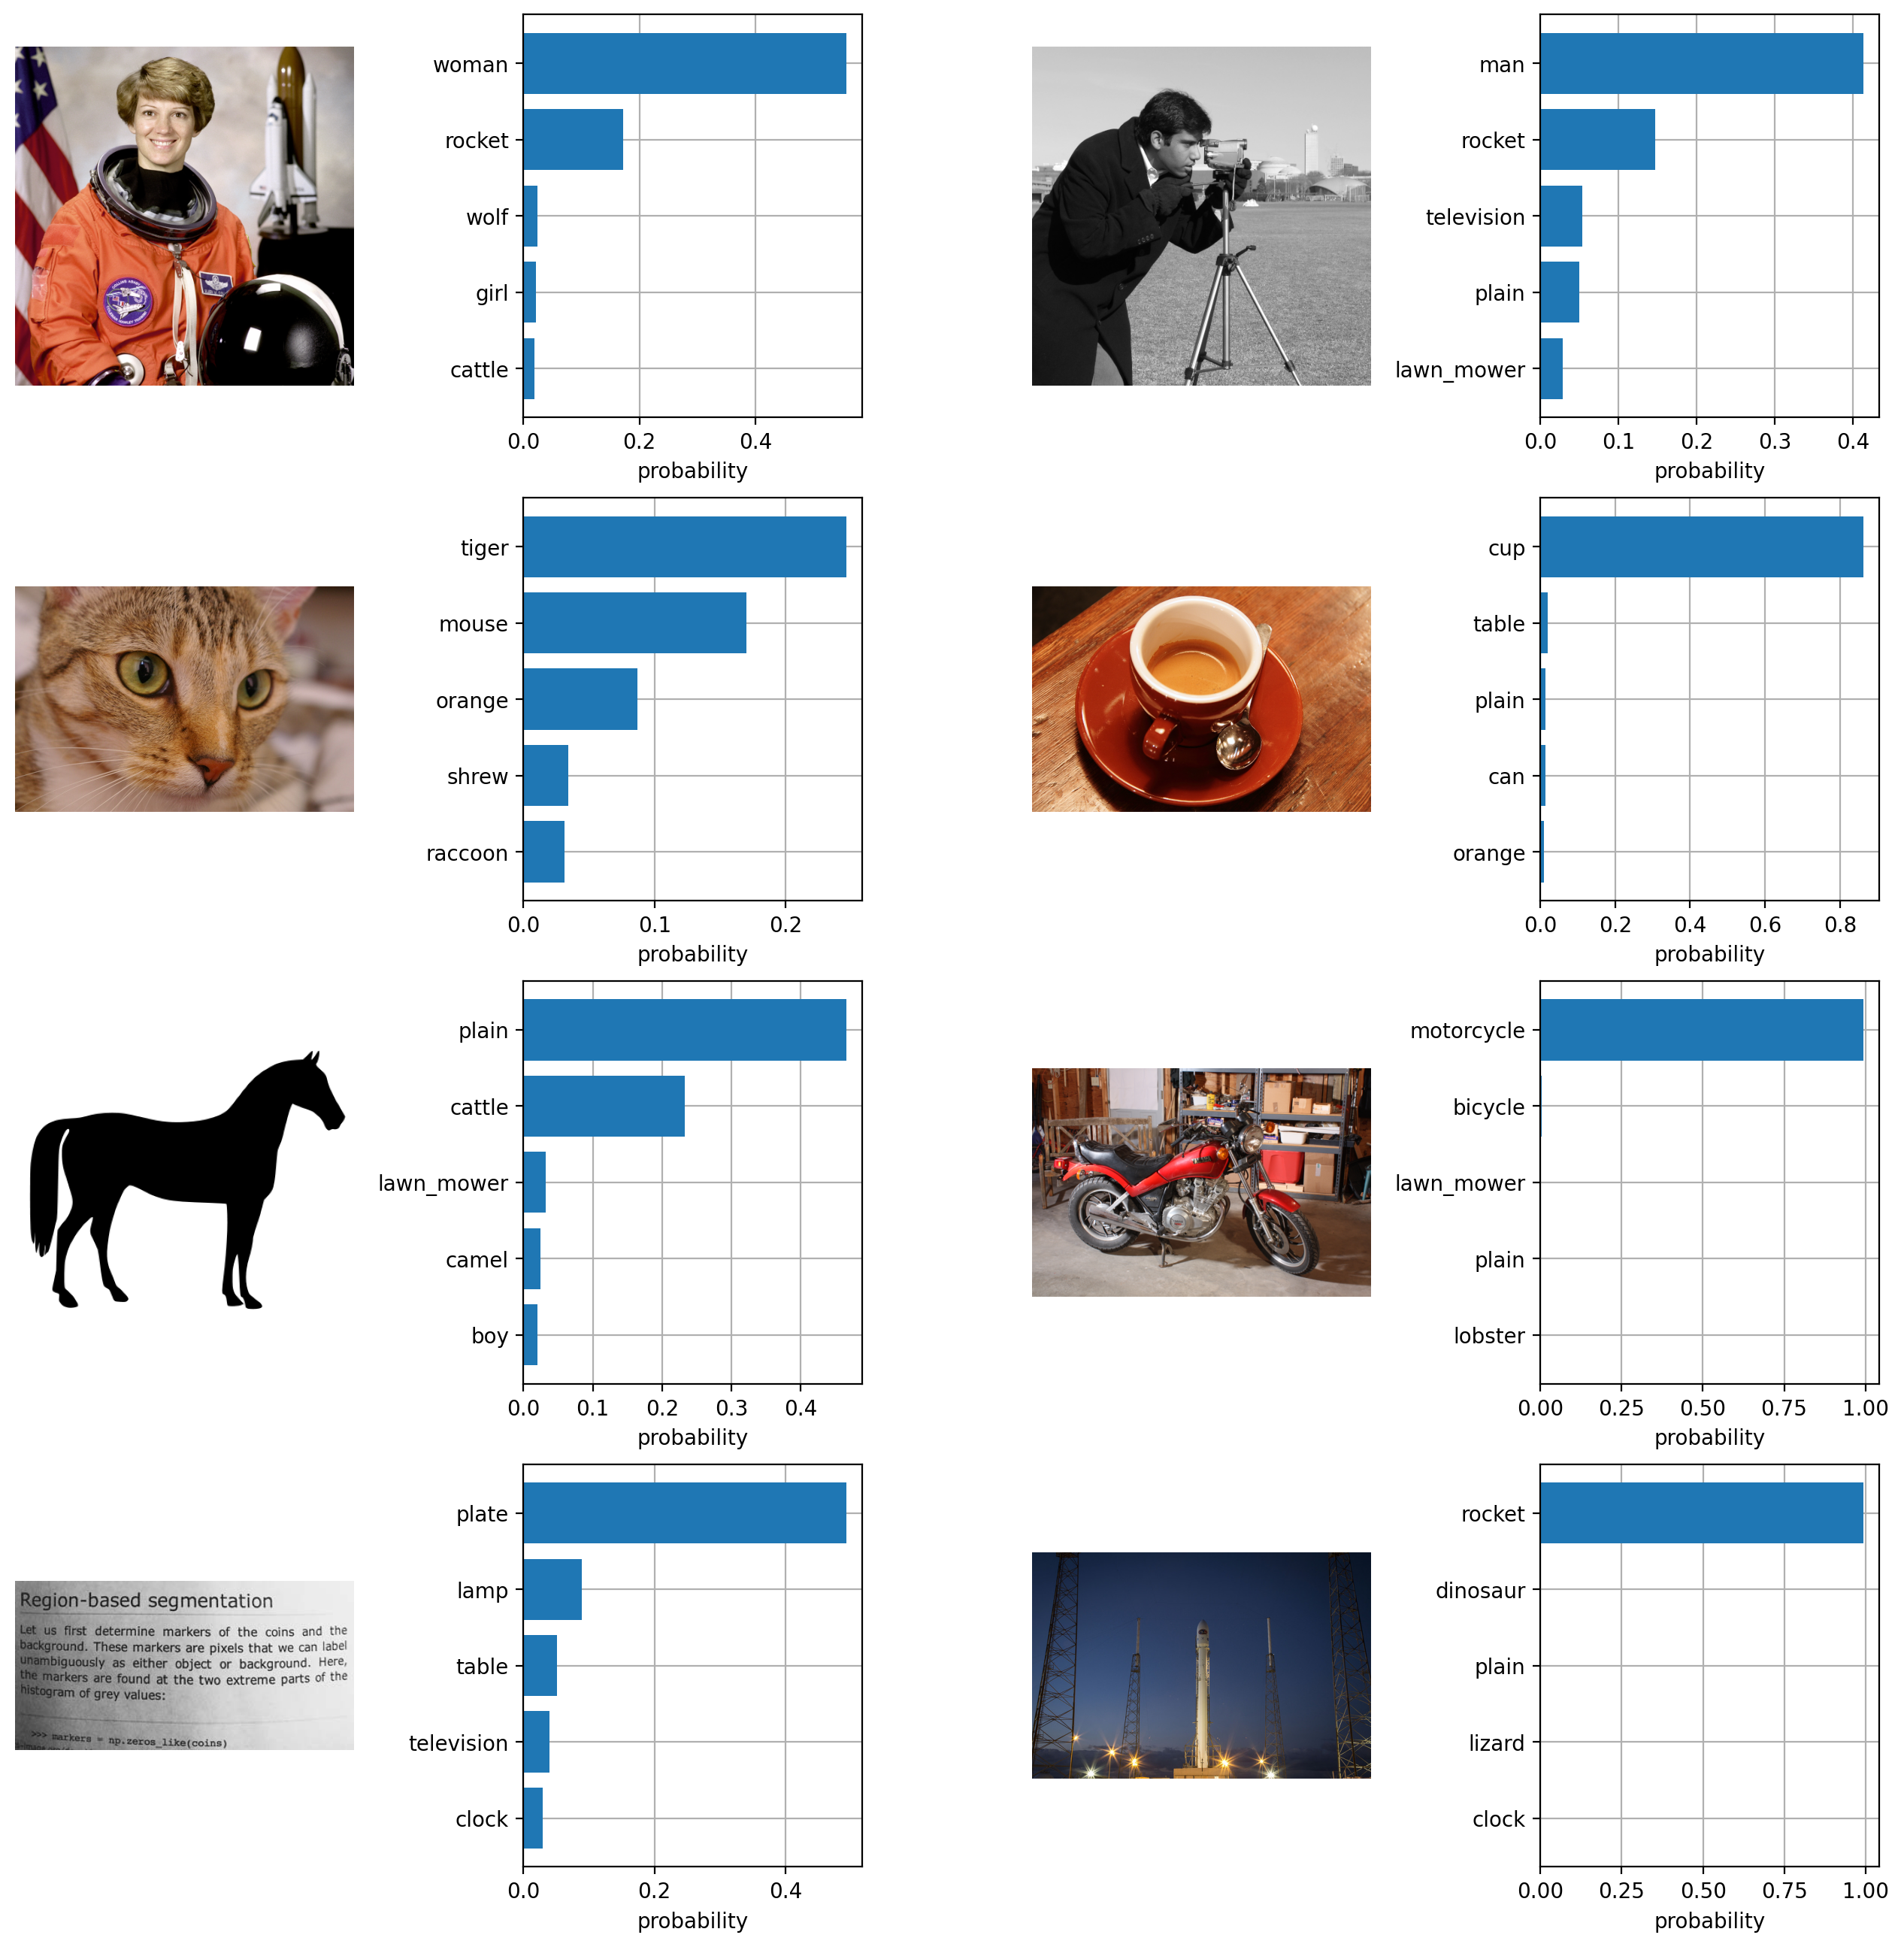

In [21]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

# Хабр

In [2]:
from sentence_transformers import SentenceTransformer
from PIL import Image

model_name = 'clip-ViT-L-14'
st_model = SentenceTransformer(model_name)

def vectorize_img(img_path, model=st_model):
    img = Image.open(img_path)
    return st_model.encode(img)

c:\Users\ilyav\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ilyav\.cache\huggingface\hub\models--sentence-transformers--clip-ViT-L-14. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installe

In [3]:
import pandas as pd
import os

def create_images_db(images_folder, model=st_model):
    data_dict = dict()
    for file_name in os.listdir(images_folder):
        if os.path.isfile(images_folder + file_name):
            image_path = images_folder + file_name
            emb = vectorize_img(image_path)
            data_dict[file_name] = emb
    return pd.DataFrame(data_dict.items(), columns=['Image', 'Embedding'])

In [4]:
import numpy as np

def import_images_db(file_path):
    data_df = pd.read_json(file_path)
    data_df['Embedding'] = data_df['Embedding'].apply(lambda x: np.array(x))
    return data_df

In [5]:
from scipy import spatial

def calculate_cos_dist(emb_a, emb_b):
    result_distance = spatial.distance.cosine(emb_a, emb_b)
    return result_distance

In [6]:
import copy

def found_similar_images(input_img_path, images_db, n=7):
    input_vec = vectorize_img(input_img_path)
    result_df = copy.deepcopy(images_db)
    result_df['Distance_with_input'] = result_df.apply(lambda x: calculate_cos_dist(input_vec, x['Embedding']), axis=1)
    result_df_sorted = result_df.sort_values('Distance_with_input').reset_index()
    return result_df_sorted['Image'].head(n)

In [7]:
images_folder = 'dataset/'
images_db = create_images_db(images_folder)


In [51]:
input_img_path = 'dataset/0777.png'
result_df = found_similar_images(input_img_path, images_db)
print(sorted(result_df.values))

['0276.png', '0777.png', '1160.png', '3251.png', '6730.png', '8283.png', '8756.png']


In [57]:
r = list(result_df.values)

r.remove('0777.png')

In [58]:
r

['8283.png', '8756.png', '3251.png', '1160.png', '6730.png', '0276.png']

In [9]:
result_df.values

array(['0003.png', '4604.png', '3100.png', '6082.png', '8194.png',
       '1051.png', '8440.png'], dtype=object)

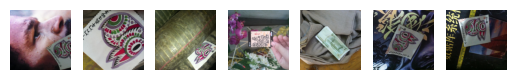

In [10]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showImagesHorizontally(list_of_files):
    fig = figure()
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = list_of_files[i]
        imshow(image,cmap='Greys_r')
        axis('off')
        
files=[]
for res in result_df.values:
    image = Image.open(os.path.join("dataset", res)).convert("RGB")
    files.append(image)
showImagesHorizontally(files)

In [59]:
import cv2
import os
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        images.append(filename)
    return images
def showImagesHorizontally(list_of_files):
    fig = figure()
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = list_of_files[i]
        imshow(image,cmap='Greys_r')
        axis('off')
X = load_images_from_folder("dataset")
otvet = pd.DataFrame(columns=['filename','ranking'])
k=0
for x in X:
    input_img_path = 'dataset/'+x
    result_df = found_similar_images(input_img_path, images_db)
    r = list(result_df.values)
    r.remove(x)
    print(f"{x},{' '.join(r)}")
    otvet.loc[len(otvet)] = [x,' '.join(r)]

0000.png,2023.png 1381.png 5924.png 8492.png 5207.png 8222.png
0001.png,5721.png 5029.png 5193.png 3598.png 1995.png 1149.png
0002.png,1858.png 7688.png 8914.png 4568.png 2448.png 5492.png
0003.png,4604.png 3100.png 6082.png 8194.png 1051.png 8440.png
0004.png,7238.png 2961.png 2462.png 2470.png 0258.png 6371.png
0005.png,7140.png 1750.png 5288.png 1053.png 5877.png 5530.png
0006.png,2655.png 3057.png 6767.png 2561.png 4407.png 7101.png
0007.png,2393.png 4321.png 6145.png 2051.png 1319.png 5413.png
0008.png,8385.png 1310.png 0206.png 0217.png 6388.png 3206.png
0009.png,2419.png 8562.png 6452.png 8060.png 2702.png 4367.png
0010.png,2695.png 7850.png 7058.png 2082.png 7847.png 2044.png
0011.png,6970.png 3181.png 1587.png 4988.png 3199.png 6672.png
0012.png,2002.png 9581.png 7481.png 0515.png 4194.png 3847.png
0013.png,5353.png 5787.png 6383.png 5423.png 5112.png 4422.png
0014.png,7369.png 0519.png 1769.png 4276.png 2178.png 6028.png
0015.png,7122.png 5120.png 0959.png 7849.png 7623.png 5

In [22]:
otvet.loc[len(otvet)] = ['1','2']

In [61]:
otvet.iloc[1023]

filename                                             1023.png
ranking     7946.png 4648.png 7340.png 2110.png 4314.png 5...
Name: 1023, dtype: object

In [62]:
otvet.to_csv('submission.csv', sep=',', index=False)
